# Air Force Cadet Career Problem Walkthrough

This jupyter notebook demonstrates the implementation of the Air Force Cadet Career Problem (afccp) python module developed and maintained by Griffen Laird for his master's thesis, and now implemented by AFPC/DSYA in the process to match Air Force cadets to their career fields. This notebook showcases the "CadetCareerProblem" class, which is a class object of these specific problem instances. This class pertains to specific instances of the AFSC matching problem (AFCCP) and there are numerous class methods pertaining to importing, exporting, solving, etc. Let's first discuss some preliminary material for this module.  

## Preliminaries

This module's main purpose is to automate as much of the matching process as possible. If we can focus on the general application of solving these problems, there is no reason that AFPC needs to spend so much time each year cleaning data and figuring out how to assign cadets to their AFSCs! That's where afccp comes in.

### Changing Directory

To keep things cleaner, I put all of the executable files (this notebook included) in their own folder. When we run one of those files, the working directory is initially that subfolder and so we would only have access to the files and modules within that sub-folder. This isn't going to work, so we need to change the working directory.

In [1]:
import os

# Obtain initial working directory
dir_path = os.getcwd() + '/'
print('initial working directory:', dir_path)

# Get main afccp folder path
index = dir_path.find('afccp') 
dir_path = dir_path[:index + 6]

# Update working directory
os.chdir(dir_path)
print('updated working directory:', dir_path)

initial working directory: /Users/griffenlaird/Desktop/Coding Projects/afccp/afccp/executables/examples/
updated working directory: /Users/griffenlaird/Desktop/Coding Projects/afccp/


### globals.py

This script figures out the user's directory information and determines which python packages the user has access to. The majority of the packages I use are common python packages (pandas, numpy, matplotlib, etc.) but there are a few exceptions. The libraries pyomo (optimization package for python), sdv (synthetic data vault useful for generating realistic data --CTGAN is found here!), and sklearn (Sci-kit learn but it's version 0.0 since for whatever reason this is the one I found that performs MDS for the solution similarity plots) are some of the less common ones. This script checks these packages directly and prints out whether we have them or not. I recommend creating a virtual environment using the requirements.txt file in the repository so that you have all the required packages!

In [2]:
from afccp.core.globals import *

Running on Griffen's Macbook
Sensitive data folder not found.
Pyomo module found.
SDV module found.
Sklearn Manifold module found.


We also print out whether or not we have the "Sensitive" data folder. Since I ultimately want to publish this module to GitHub, I have a separate folder that is only stored on my local machine that has the real cadet/AFSC data. When we commit things to GitHub, there is a "gitignore" file that prevents the sensitive data from being published. 

### Dependencies

There are many different scripts in the directory that all do different things. They all rely on eachother in different ways too. Here is a flowchart indicating the order of dependencies of the various scripts

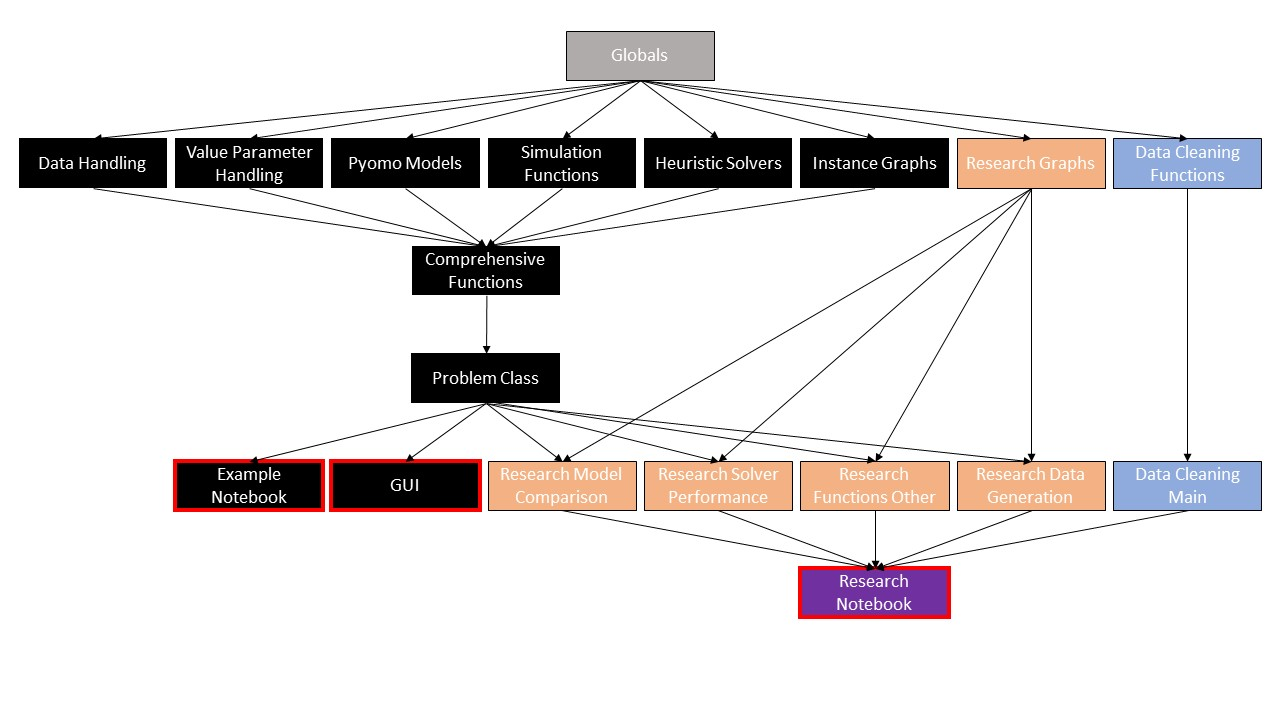

The black rectangles are all the main "instance" handling functions. They pertain to the actual CadetCareerProblem instances themselves. Each of the six scripts represented by the black rectangles in the second layer of the flowchart all process different aspects of a particular AFSC/cadet dataset. Importing/generating instance parameters, solving the model through different means, and exporting/visualizing the results are defined at that top layer. The "comprehensive functions" script has additional functions that aggregate the others to perform different operations. The scripts/jupyter notebooks that are intended to be executed are the ones with the thick red outlines.

The main script of functions for this project is problem_class.py. This script defines the "CadetCareerProblem" class, which contains many class methods using the various functions of the other scripts. This class is used to create an instance of the Cadet Career problem, and it is the basic building block that we can work with. The GUI and this particular notebook (Example Notebook) pulls directly from that script. I also define different thesis research scripts that contain functions pulling the AFSC Assignment problem class as well. The other jupyter notebook (Research Notebook) describes those functions. 

## CadetCareerProblem

Let's import the problem class. Chances are that you won't have all the same packages that are required for this project (unless you create a virtual environment using the requirements.txt file), so just follow the errors through (if any) and install the packages you don't have. 

In [3]:
# Import the problem class
from afccp.core.problem_class import CadetCareerProblem

If you want to start writing your own scripts or jupyter notebooks, first create a new folder in the "executables" sub-folder. Currently, there are two folders there: "examples" and "laird". This jupyter notebook is in the examples folder, so please do not make changes to this one as it is intended just to show some examples of what the problem class object can do and how it works. The other folder, "laird", has my python scripts that are just meant to test out the functionality of this module (afccp). There are two of them so I can have one for my PC laptop and one for my Mac. Create your own folder there and then add whatever files you want (.ipynb or .py) in there to use afccp. If you want to actually change some of the source code for afccp, you can do that too! We can talk more about the best way of doing that, but one way would be to just make your own scripts in the "core" folder where the others are and then you can plug whatever you need into CadetCareerProblem. As long as you don't change anything I've already done, and you just add your own stuff, then we'll be ok! Below is an example of what your import statements (and directory change because it's in the executable folder) should look like at the top of your script(s):

In [4]:
import os

# Obtain initial working directory
dir_path = os.getcwd() + '/'

# Get main afccp folder path
index = dir_path.find('afccp') 
dir_path = dir_path[:index + 6]

# Update working directory
os.chdir(dir_path)  # If we didn't do this, we wouldn't know where to find afccp

# Import the problem class
from afccp.core.problem_class import CadetCareerProblem

You may or may not have to import pandas, numpy, etc. directly as well. Pycharm is ok if I don't import those libraries on the test script (they get imported with the "from afccp.core.problem_class" statement anyway) but for some reason jupyter wants me to reimport them. It may be because .py scripts run all at once but jupyter uses individual cells and so it forgets the things it doesn't need? Idk.

### Fixed Parameters

To create an object of this class (or rather an "instance" of the problem), we first must specify the type of AFSC/cadet "fixed" data. By fixed parameters, I am referring to the aspects of the problem instance that cannot be changed by the decision maker. This is the data on the characteristics of the cadets themselves and the AFSC properties (which AFSCs are used as well as their quotas). I provide four different methods of creating an instance: generating "random" data, generating "perfect" data, generating "realistic" data, or importing the data from excel. I will discuss the first three later, but for now let's import the data from excel.

#### Problem Instance Excel Files

To import data, we need to either specify the "data_name". There are several elements to a given problem instance excel file, and so I have developed my own naming convention to handle them. Problem instance excel files are named in this structure: 'data_type data_name vp_name solution_name". The "data_type" is the type of data we're dealing with (Generated or Real). The "data_name" is a particular problem instance (set of fixed parameters). The data_name could be a particular class year, a class year with scrubbed AFSC labels, or a particular generated data instance. The "vp_name" is the set of value parameters used to fully instantiate a "fixed" problem instance. These vp names are numbered relative to the particular data instance (data_name). Lastly, the "solution_name" is the name of a particular solution for the problem. This is also labeled/numbered relative to the data instance.

In [5]:
# The filepath assumes there is an excel file in the correct folder pertaining to this problem instance
data_name = 'C'  # We only need to specify the data_name

# Create instance from this data. "printing" is optional and just prints progess updates
instance = CadetCareerProblem(data_name=data_name, printing=True)  
print('Full name:', instance.full_name)  # "data_type data_name". Main excel file name (can get more specific with solutions/vps)

Importing C problem instance...
Imported.
Full name: Real C


We now have a lot of information pertaining to problem instance "C" (a scrubbed class year). We have the set of fixed parameters and we also have various sets of value parameters and solutions to play around with. Check out the excel files themselves to see how they're all structured. 

#### "Parameters" dictionary

This "instance" object has many different attributes and methods defined that we can now access. The "parameters" of the instance are represented by a dictionary, which is an attribute of the instance object. These are the "fixed" parameters, and contain many different characteristics of this particular dataset. Most parameters are loaded in as numpy arrays.

In [6]:
# Numbers of Cadets, AFSCs, and AFSC preferences
for param in ['N', 'M', 'P']:
    print(param + ':', instance.parameters[param])

N: 1778
M: 32
P: 6


In [7]:
# Utility matrix
print(instance.parameters['utility'])

[[0.   0.17 0.   ... 0.   0.   0.  ]
 [0.   1.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.87 1.   0.   ... 0.   0.   0.  ]
 [0.2  0.25 0.   ... 0.   0.   0.  ]
 [0.   0.17 0.   ... 0.5  0.   0.  ]]


In [8]:
# Qualification matrix
print(instance.parameters['qual'])

[['P' 'D' 'P' ... 'I' 'I' 'I']
 ['P' 'M' 'P' ... 'I' 'I' 'I']
 ['D' 'P' 'M' ... 'I' 'I' 'M']
 ...
 ['P' 'P' 'P' ... 'I' 'I' 'I']
 ['P' 'M' 'P' ... 'I' 'I' 'I']
 ['D' 'P' 'P' ... 'M' 'I' 'I']]


In [9]:
# Array of AFSCs
print(instance.parameters['afsc_vector'])

['C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9' 'C10' 'C11' 'C12' 'C13'
 'C14' 'C15' 'C16' 'C17' 'C18' 'C19' 'C20' 'C21' 'C22' 'C23' 'C24' 'C25'
 'C26' 'C27' 'C28' 'C29' 'C30' 'C31' 'C32']


In [10]:
# Sets of cadets and AFSCs
for param in ['I', 'J']:
    print(param, instance.parameters[param])

I [   0    1    2 ... 1775 1776 1777]
J [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


In [11]:
# Set of cadets that are eligible for AFSC at index 23  (C24)
print('cadet indices', instance.parameters['I^E'][23])

cadet indices [   5   17   83   97   98  129  148  164  195  209  212  235  266  269
  275  280  303  400  443  500  522  535  552  594  599  603  604  629
  675  694  699  721  735  748  750  751  784  814  820  854  859  902
  910  911  918  971  982  983  999 1027 1034 1046 1093 1110 1145 1167
 1210 1222 1273 1319 1349 1365 1385 1388 1416 1417 1436 1440 1458 1471
 1475 1484 1510 1511 1513 1529 1550 1634 1698 1705 1715 1719]


In [12]:
# Set of USAFA cadets that are eligible for AFSC at index 23 (C24)
print('USAFA cadet indices', instance.parameters['I^D']['USAFA Proportion'][23]) 

# ['I^D'][objective][AFSC index] is how I do it there^^^^
pass

USAFA cadet indices [   5   98  148  164  280  303  500  522  535  604  699  902  971 1046
 1110 1145 1210 1273 1417 1471 1475 1510 1511 1513 1529 1698 1715]


In [13]:
# Set of AFSCs for which the cadet at index 0 is eligible
print('AFSC indices', instance.parameters['J^E'][0])
print('AFSC names', instance.parameters['afsc_vector'][instance.parameters['J^E'][0]])

AFSC indices [ 0  1  2  4  5  6  7  8 10 18 19]
AFSC names ['C1' 'C2' 'C3' 'C5' 'C6' 'C7' 'C8' 'C9' 'C11' 'C19' 'C20']


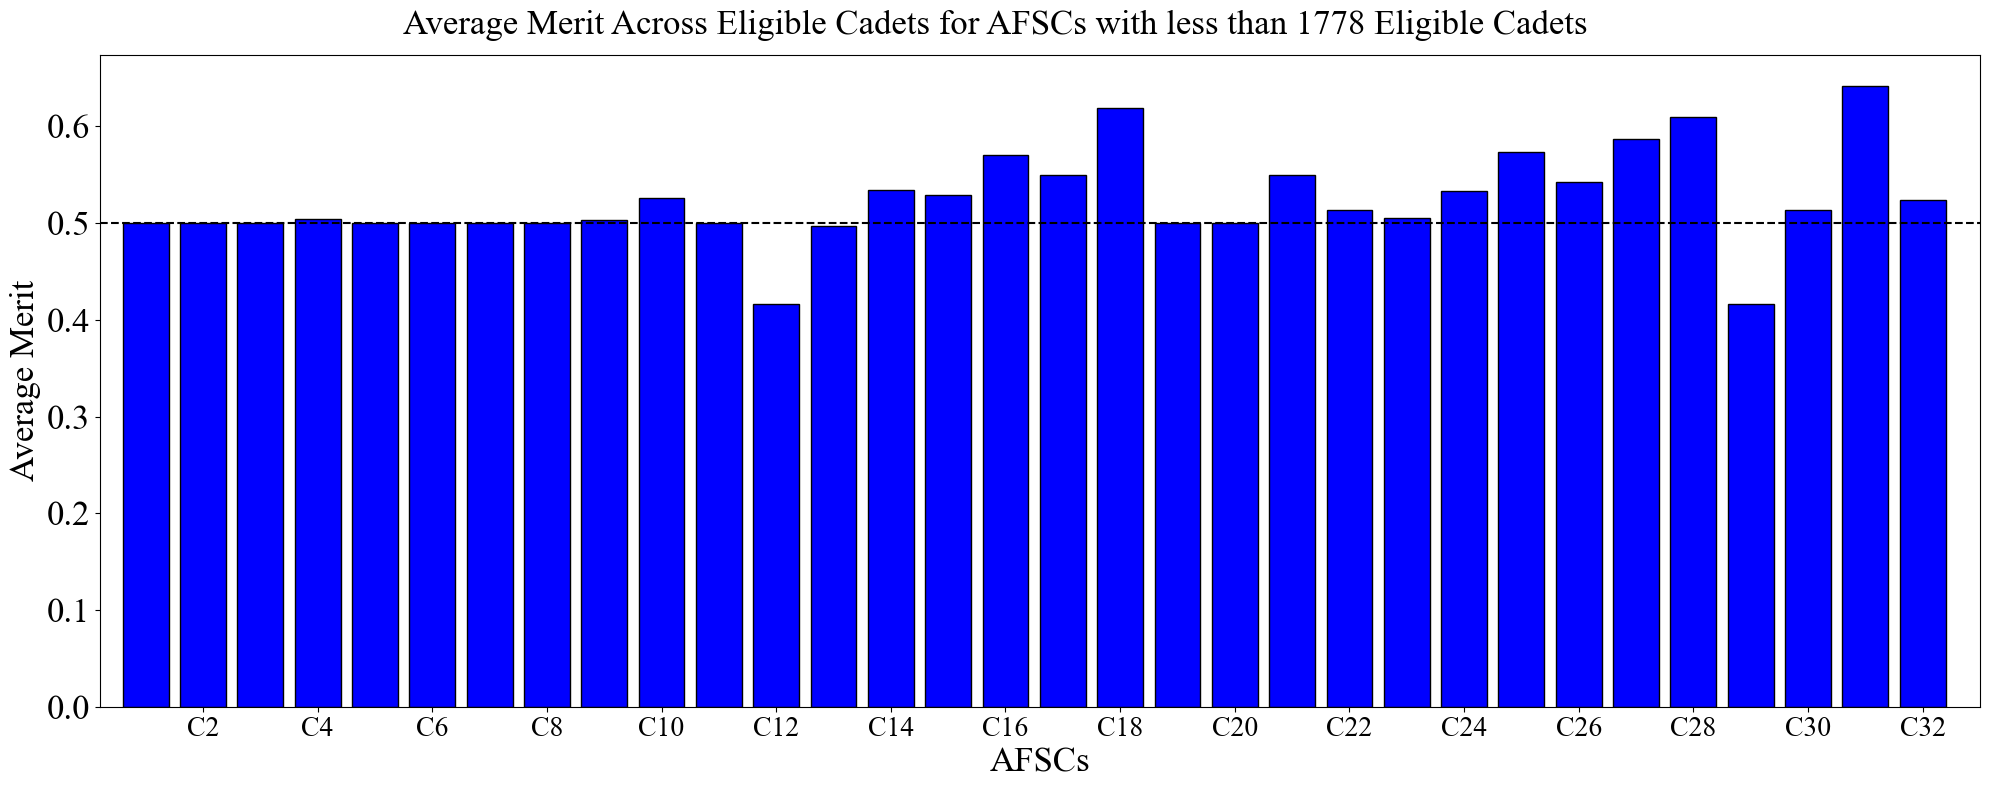

In [14]:
# Now let's show the data using one of our methods
figsize=(20, 8)  # For some reason the default (16, 10) just doesn't look great in this notebook
chart = instance.display_data_graph({"graph":'Average Merit', "save": False, "figsize": figsize, "bar_color": "blue"})

There are many other parameters to this method that control the size of the different fonts, colors, titles, and so on.

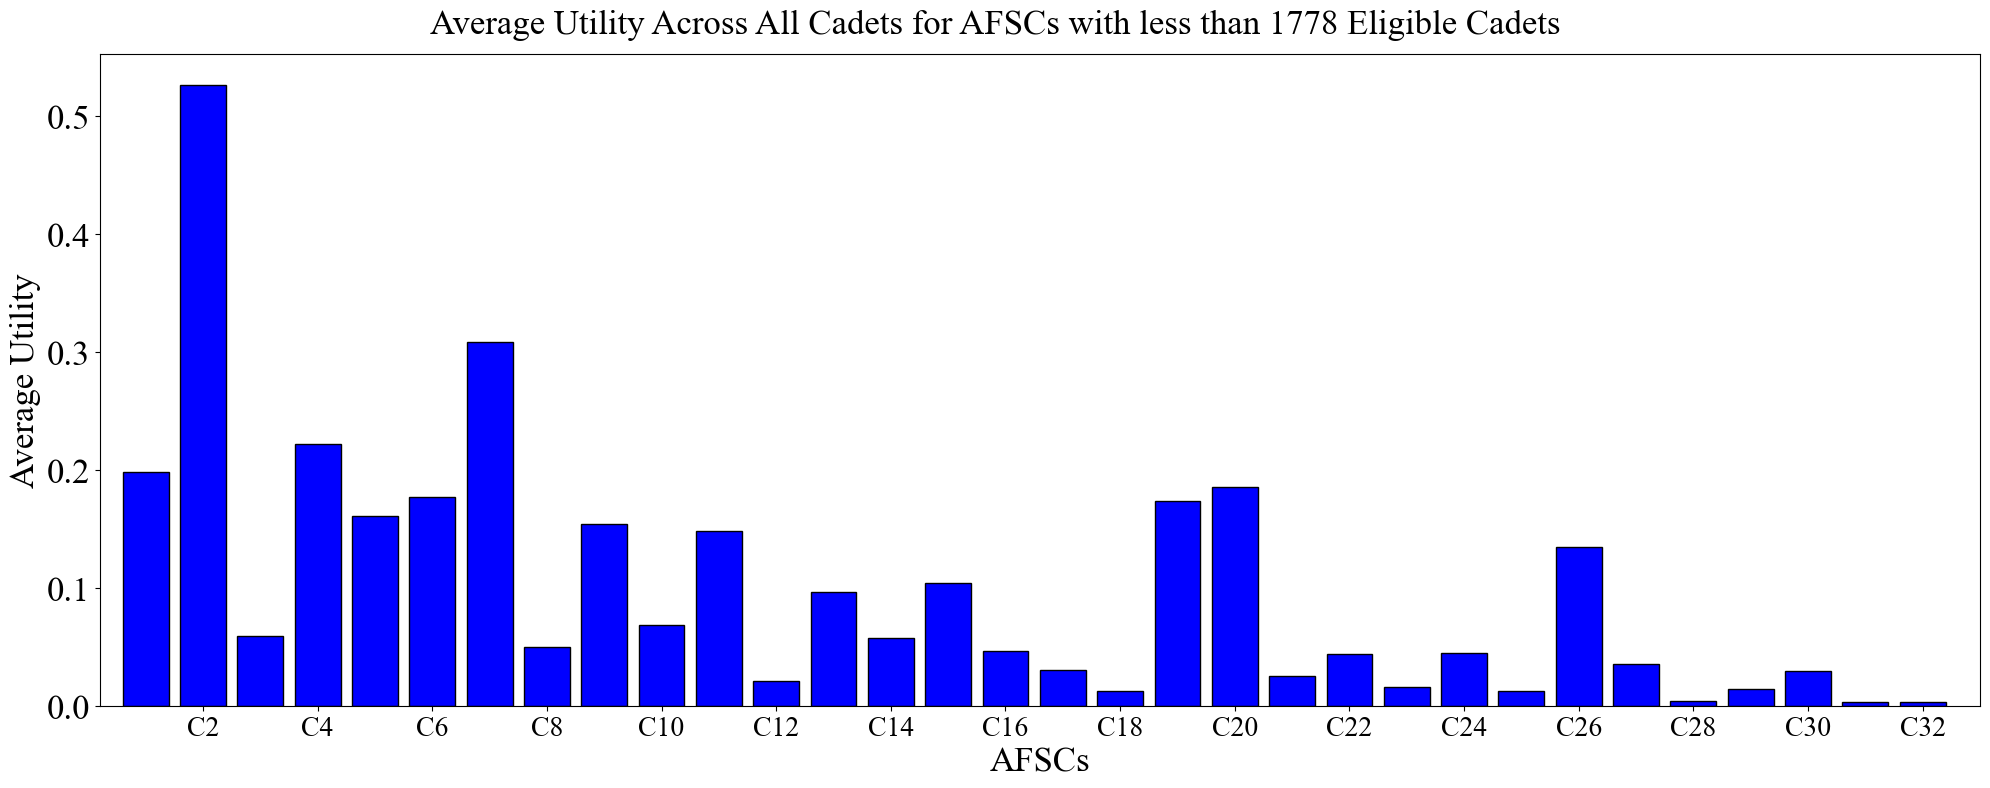

In [15]:
# We can look at the average utility placed on each of the AFSCs
chart = instance.display_data_graph({"graph": "Average Utility", "eligibility": False})

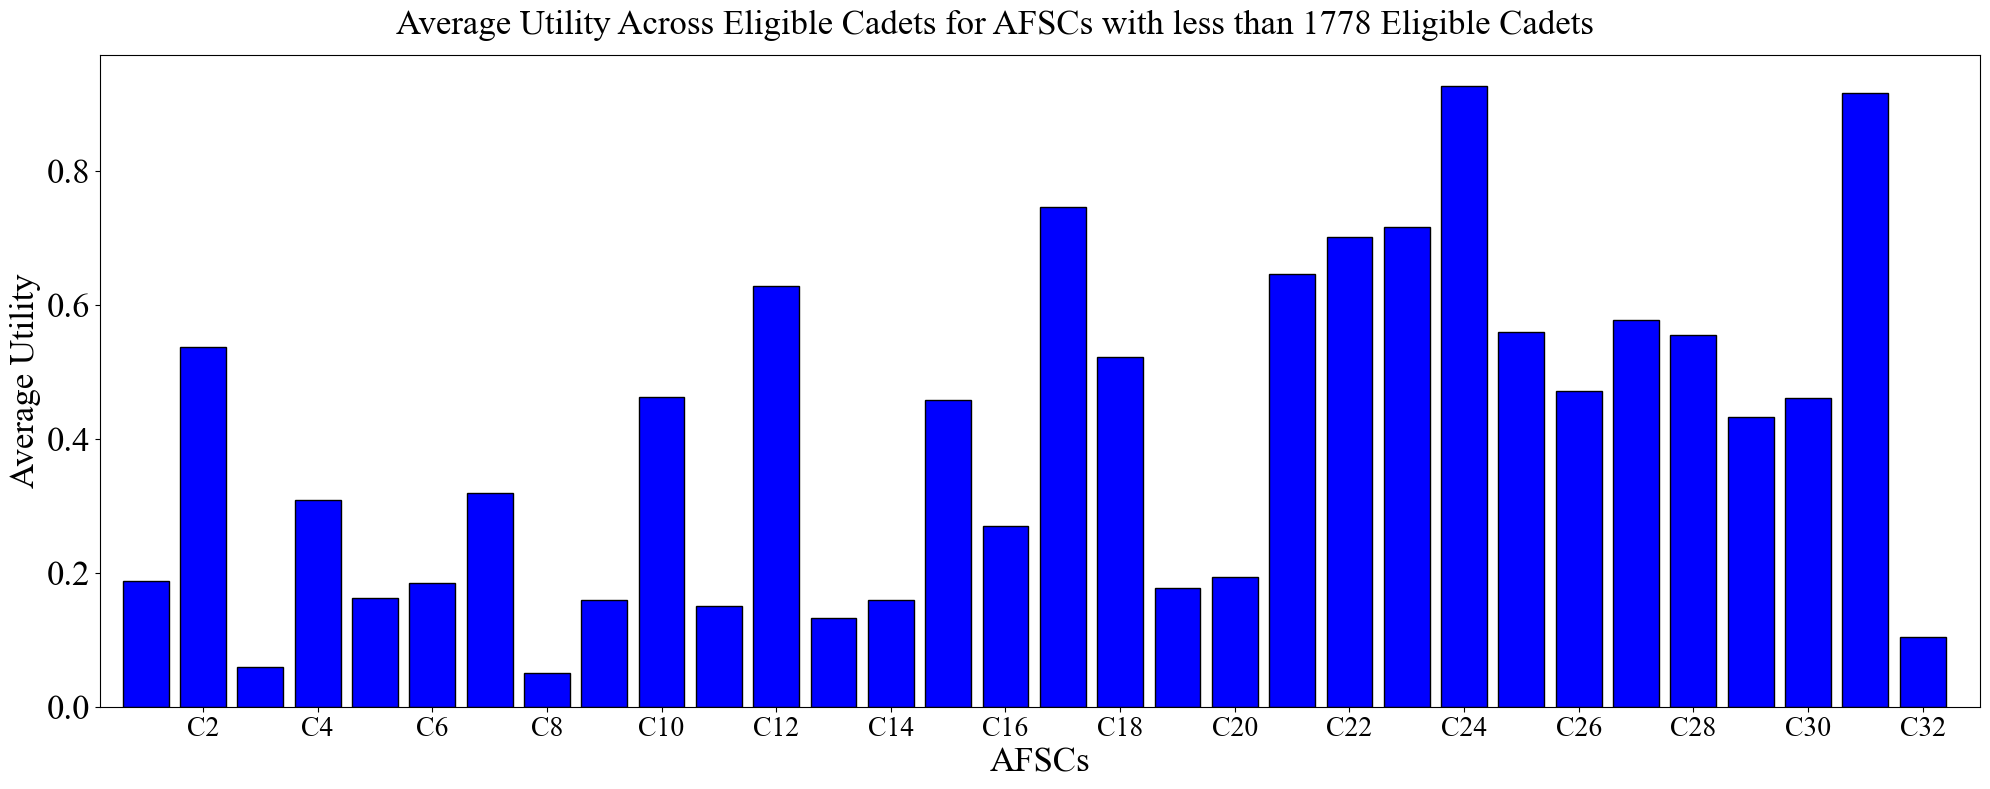

In [16]:
# We can also look at the average utility placed on each of the AFSCs of the set of eligible cadets for each AFSC
chart = instance.display_data_graph({"graph": "Average Utility", "eligibility": True}) 

# This is probably more fair since most cadets aren't going to place preferences on AFSCs they're not eligible for
pass

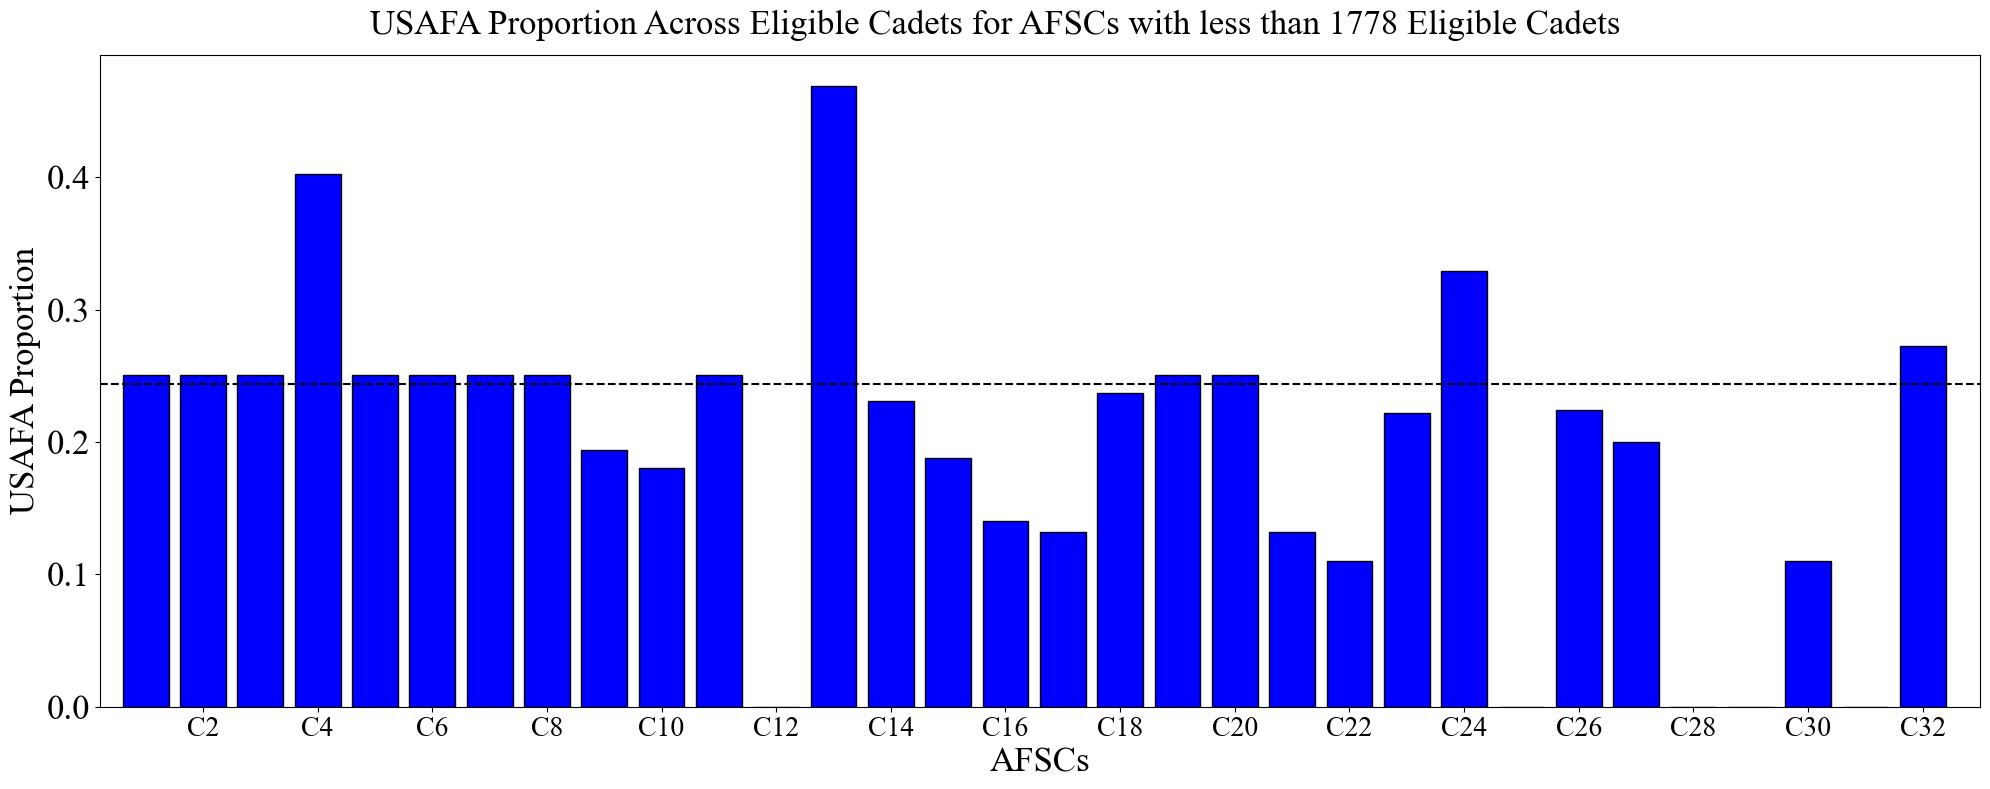

In [17]:
chart = instance.display_data_graph({"graph": 'USAFA Proportion'}) 

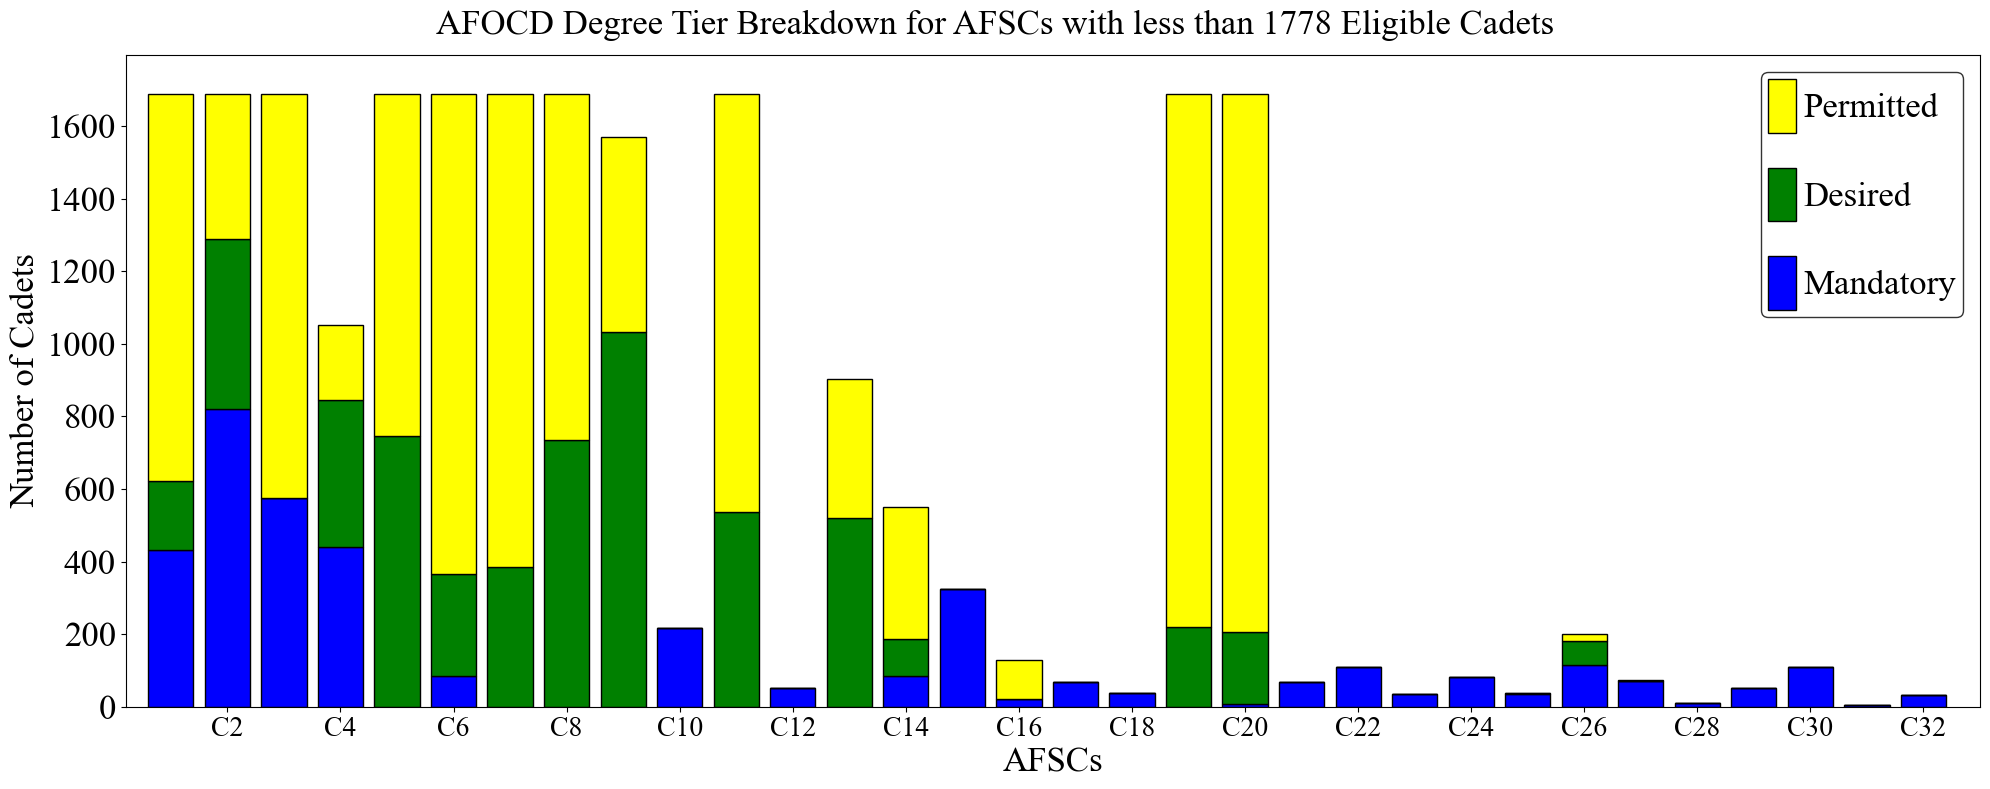

In [18]:
chart = instance.display_data_graph({"graph": 'AFOCD Data'}) 

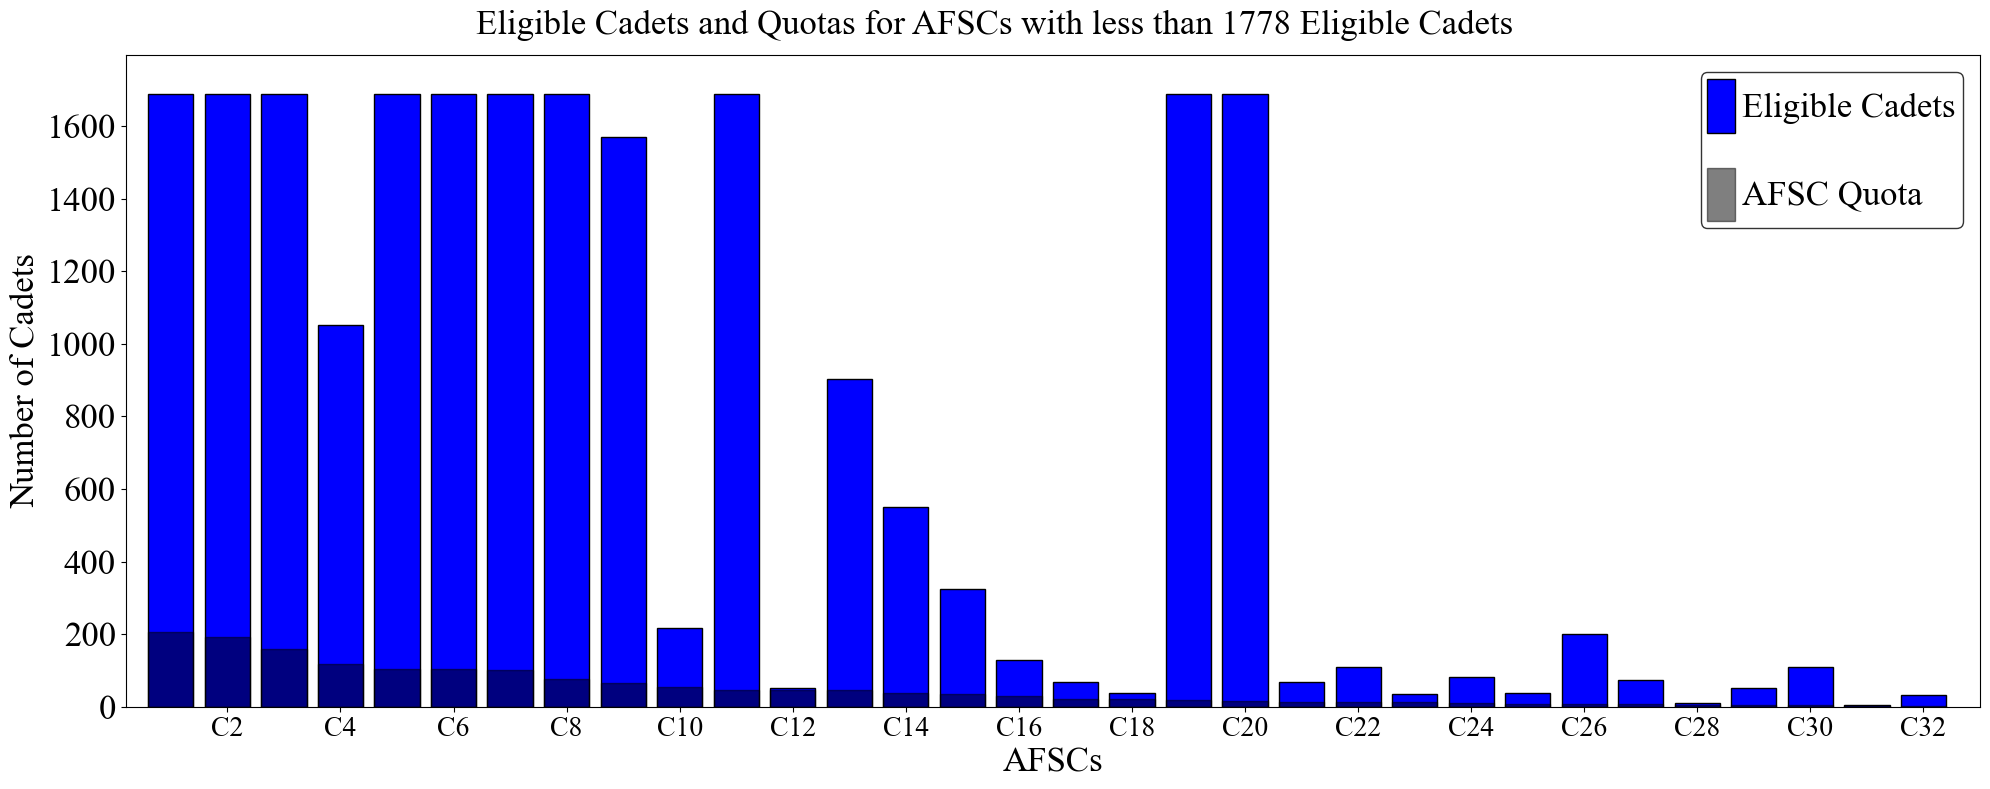

In [19]:
chart = instance.display_data_graph({"graph": 'Eligible Quota'})

One thing you'll notice is that the title always says "for AFSCs with less than 1778 Eligible Cadets". This is because we can also "zoom in" on the smaller AFSCs if need be using the "eligibility_limit" parameter. For example

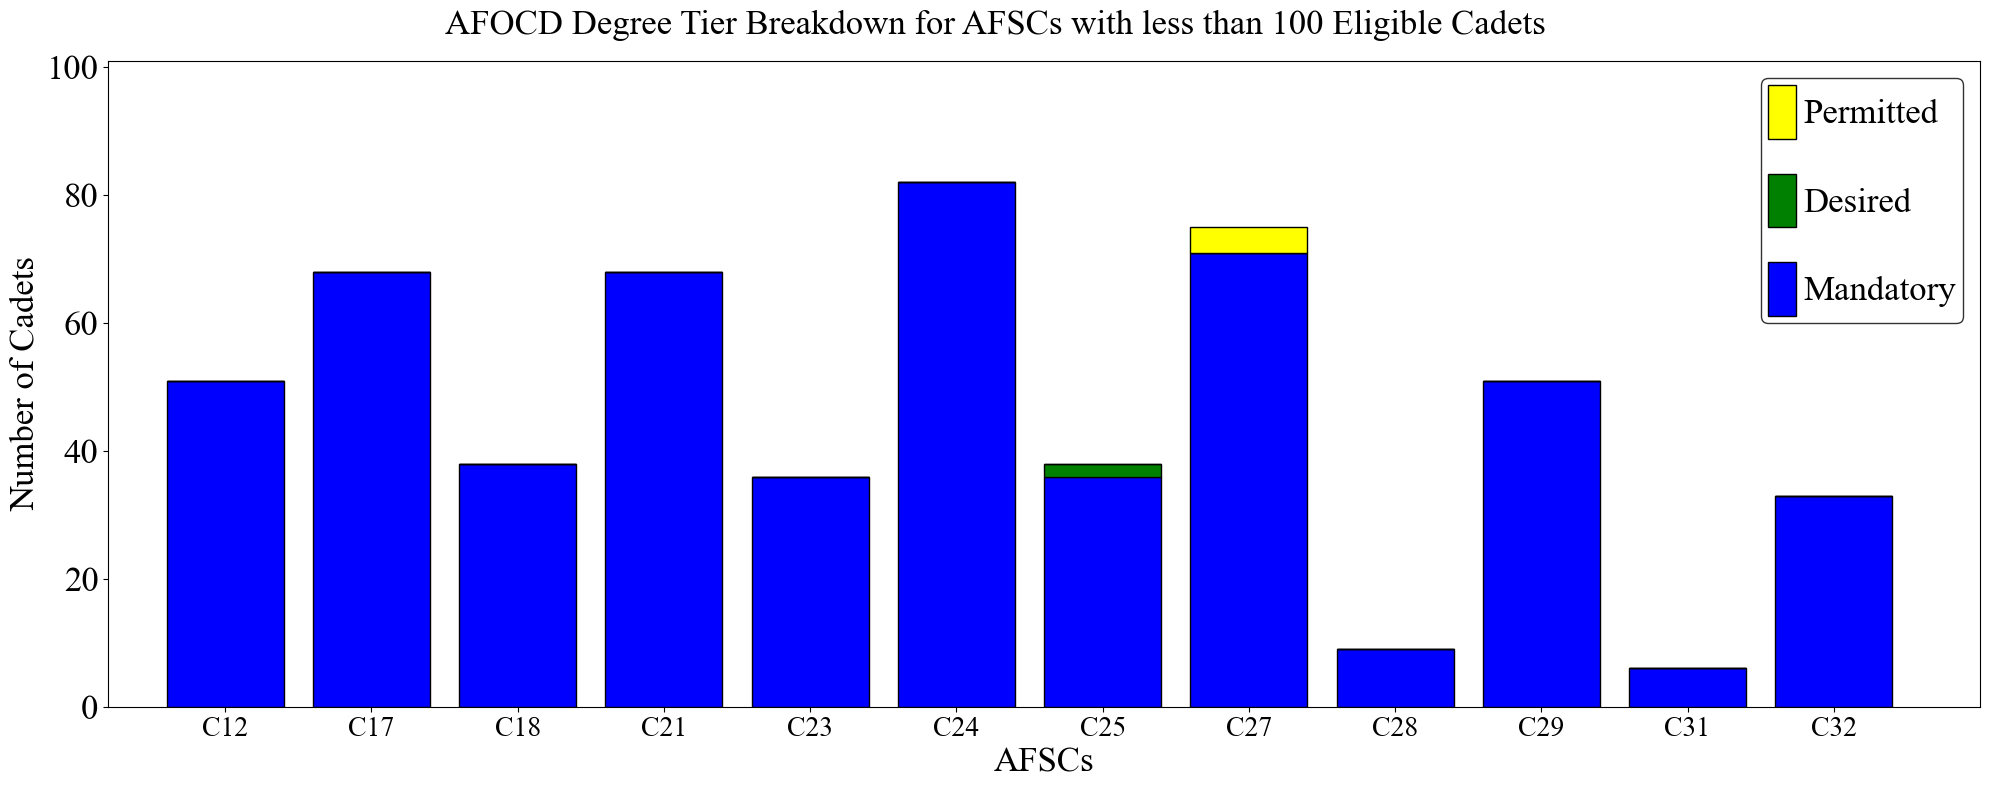

In [20]:
chart = instance.display_data_graph({"graph": 'AFOCD Data', "eligibility_limit": 100, "skip_afscs": False}) 

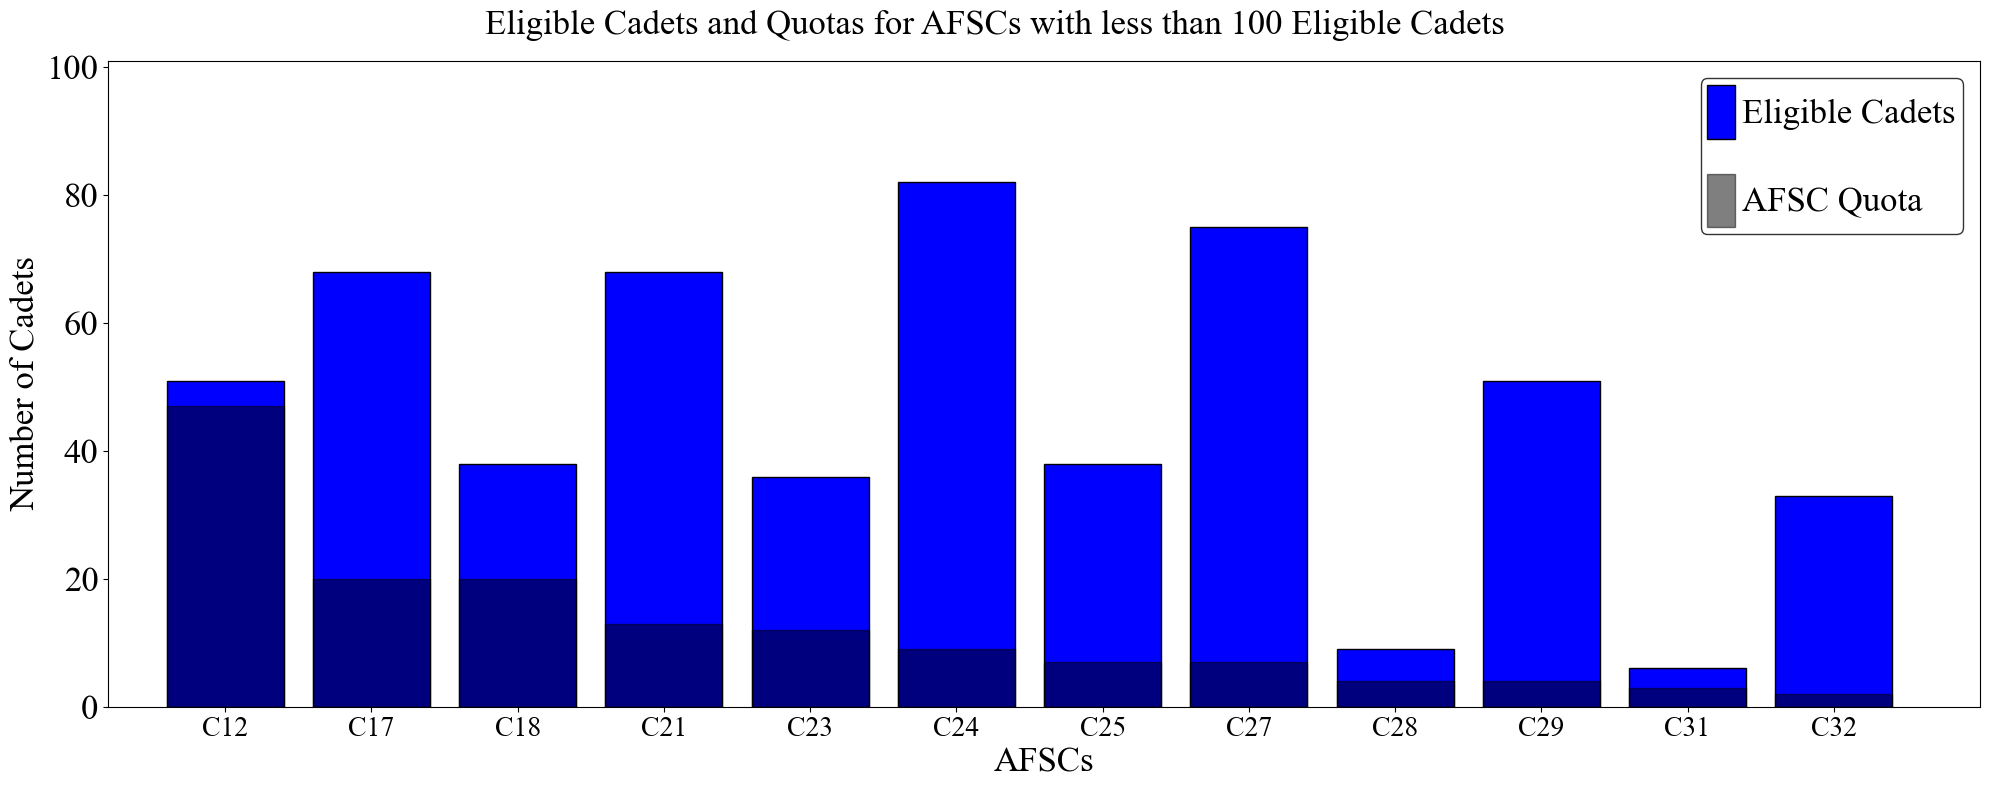

In [21]:
chart = instance.display_data_graph({"graph": 'Eligible Quota', "eligibility_limit": 100}) 

Initially, C12 was a problem up there! I reduced its quota to reflect the actual number of cadets that were assigned

### Value Parameters

In [22]:
# Import libraries that for some reason need to be imported again despite being included in afccp files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

So far, we've only seen the fixed parameters of the model. We have not specified any weight and value parameters. For this project, I refer to all of these parameters simply as "value parameters". The naming convention for value parameters is simple. The first set for a particular problem instance is called "VP", and then every one after that is "VP_2", "VP_3", etc.

In [23]:
# Set the value parameters for the instance (default vp_name is "VP" but this parameter is shown so you can see)
instance.set_instance_value_parameters(vp_name='VP')
print(instance.full_name)  # New piece of information for this instance object!

Real C VP


#### "Value Parameters" Dictionary

Now we have our "value parameters"! The value parameters are defined as a dictionary which is an attribute of the problem class object. Dictionaries are mutable, which is very nice when we want to start changing weights on different objective components

In [24]:
# Set of potential objectives
objectives = instance.value_parameters['objectives']
print(objectives)

['Merit' 'USAFA Proportion' 'Combined Quota' 'USAFA Quota' 'ROTC Quota'
 'Mandatory' 'Desired' 'Permitted' 'Utility']


In [25]:
# Set of objectives that AFSC ("C22") cares about
indices = instance.value_parameters['K^A'][21]
print('objective indices:', indices)
print('objectives:', objectives[indices])

objective indices: [0 1 2 5 8]
objectives: ['Merit' 'USAFA Proportion' 'Combined Quota' 'Mandatory' 'Utility']


In [26]:
# Set of objectives that AFSC ("C22") is constraining
indices = instance.value_parameters['K^C'][21]
print('objective indices:', indices)
print('objectives:', objectives[indices])

objective indices: [0 2 5]
objectives: ['Merit' 'Combined Quota' 'Mandatory']


In [27]:
# AFSC individual weight
print('AFSC weight function:', instance.value_parameters['afsc_weight_function'])  # Piece-wise function here!
print('AFSC "local" weights:', instance.value_parameters['afsc_weight'])  # sum to 1

AFSC weight function: Piece
AFSC "local" weights: [0.05077467 0.0456774  0.0456774  0.04057962 0.04057962 0.04057962
 0.04057962 0.03548235 0.03548235 0.03548235 0.0304846  0.0304846
 0.0304846  0.0304846  0.0304846  0.0304846  0.02538733 0.02538733
 0.02538733 0.02538733 0.02538733 0.02538733 0.02538733 0.02538733
 0.02538733 0.02538733 0.02538733 0.02538733 0.02538733 0.02538733
 0.02538733 0.02538733]


#### Weights on AFSCs and Cadets

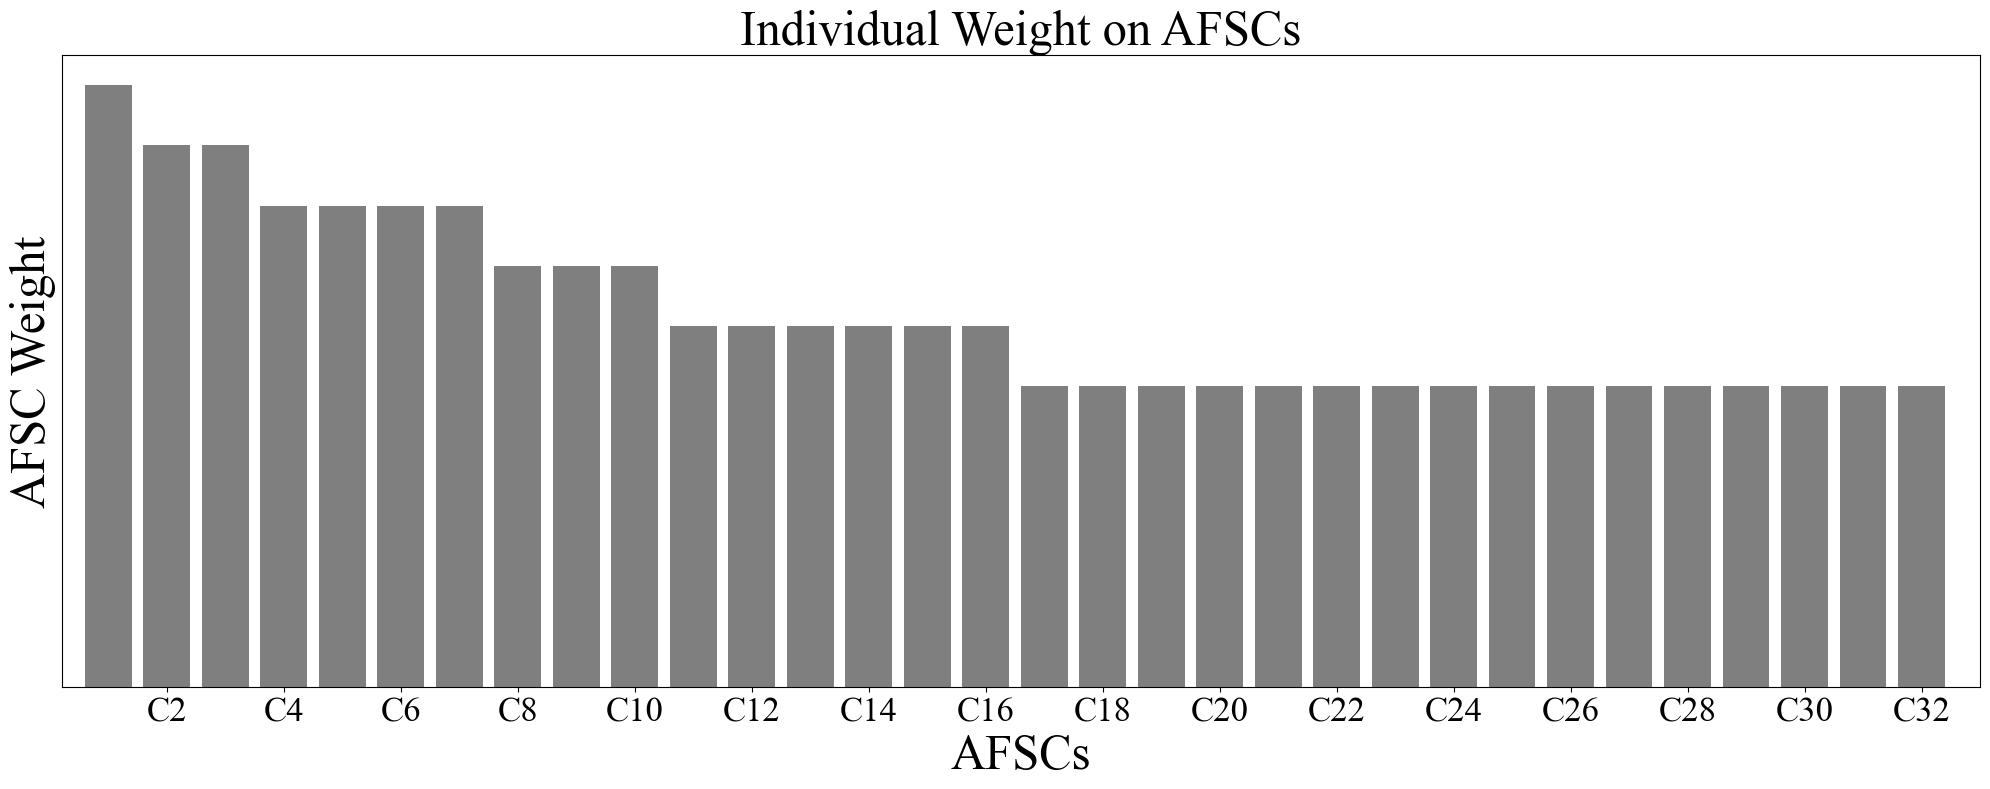

In [28]:
# Let's visualize the weights on the AFSCs
chart = instance.display_weight_function(cadets=False, figsize=figsize)

Let's scale these local weights so that we can interpret them better. The "swing" weights don't have to sum to 1, but the top weighted AFSC will have a swing weight of 100. Every other AFSC's swing weight will be in reference to that leader.

In [29]:
# grab "swing weights" so we can interpret weights better
swing_weights = instance.value_parameters['afsc_weight'] / max(instance.value_parameters['afsc_weight'])
swing_weights = np.around(swing_weights * 100, 2)
print('initial swing weights', swing_weights)

initial swing weights [100.    89.96  89.96  79.92  79.92  79.92  79.92  69.88  69.88  69.88
  60.04  60.04  60.04  60.04  60.04  60.04  50.    50.    50.    50.
  50.    50.    50.    50.    50.    50.    50.    50.    50.    50.
  50.    50.  ]


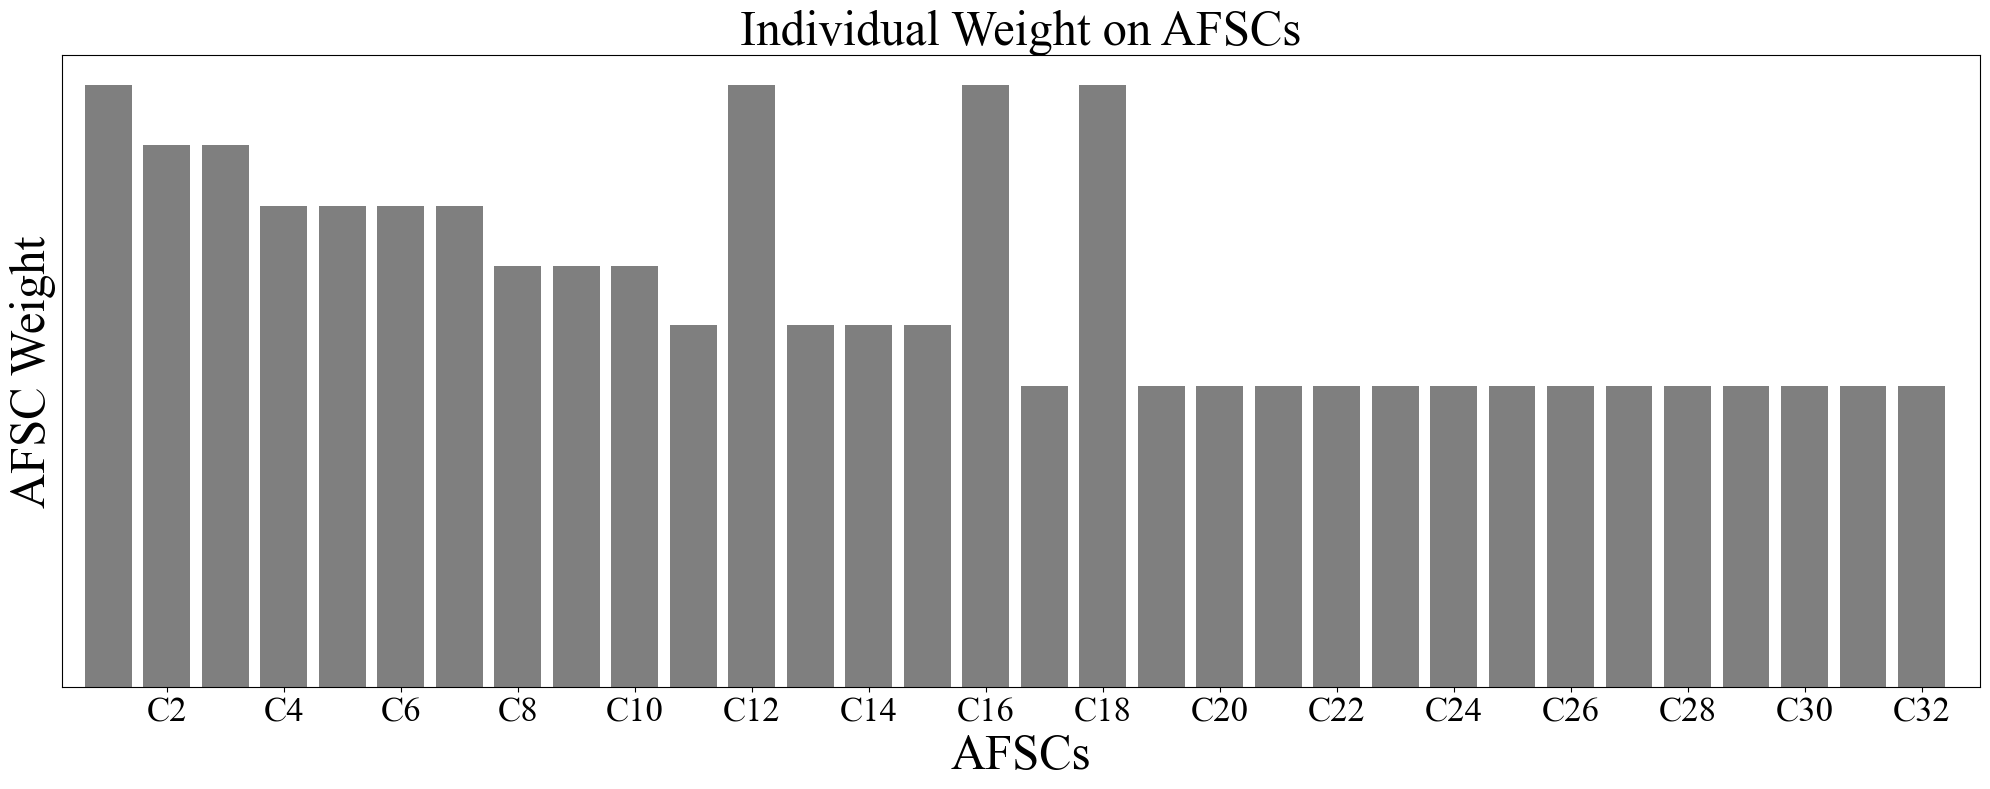

In [30]:
# Change AFSC weight
for afsc in ['C12', 'C16', 'C18']:
    j = np.where(instance.parameters['afsc_vector'] == afsc)[0][0]
    swing_weights[j] = 100  # make them tied with the top weighted AFSC
    
# Convert back to "local weights"
instance.value_parameters['afsc_weight'] = swing_weights / sum(swing_weights)

# Plot new weights
chart = instance.display_weight_function(cadets=False, figsize=figsize)

In [31]:
# We can also change the weights back to what they were before
instance.change_weight_function(cadets=False, function='Piece')

In [32]:
# Cadet individual weight
print('Cadet weight function:', instance.value_parameters['cadet_weight_function'])  # Linear function of merit here!
print('Cadet local weights:', instance.value_parameters['cadet_weight'])  # sum to 1

Cadet weight function: Linear
Cadet local weights: [0.00032369 0.00040685 0.00034337 ... 0.00056796 0.0004615  0.00073023]


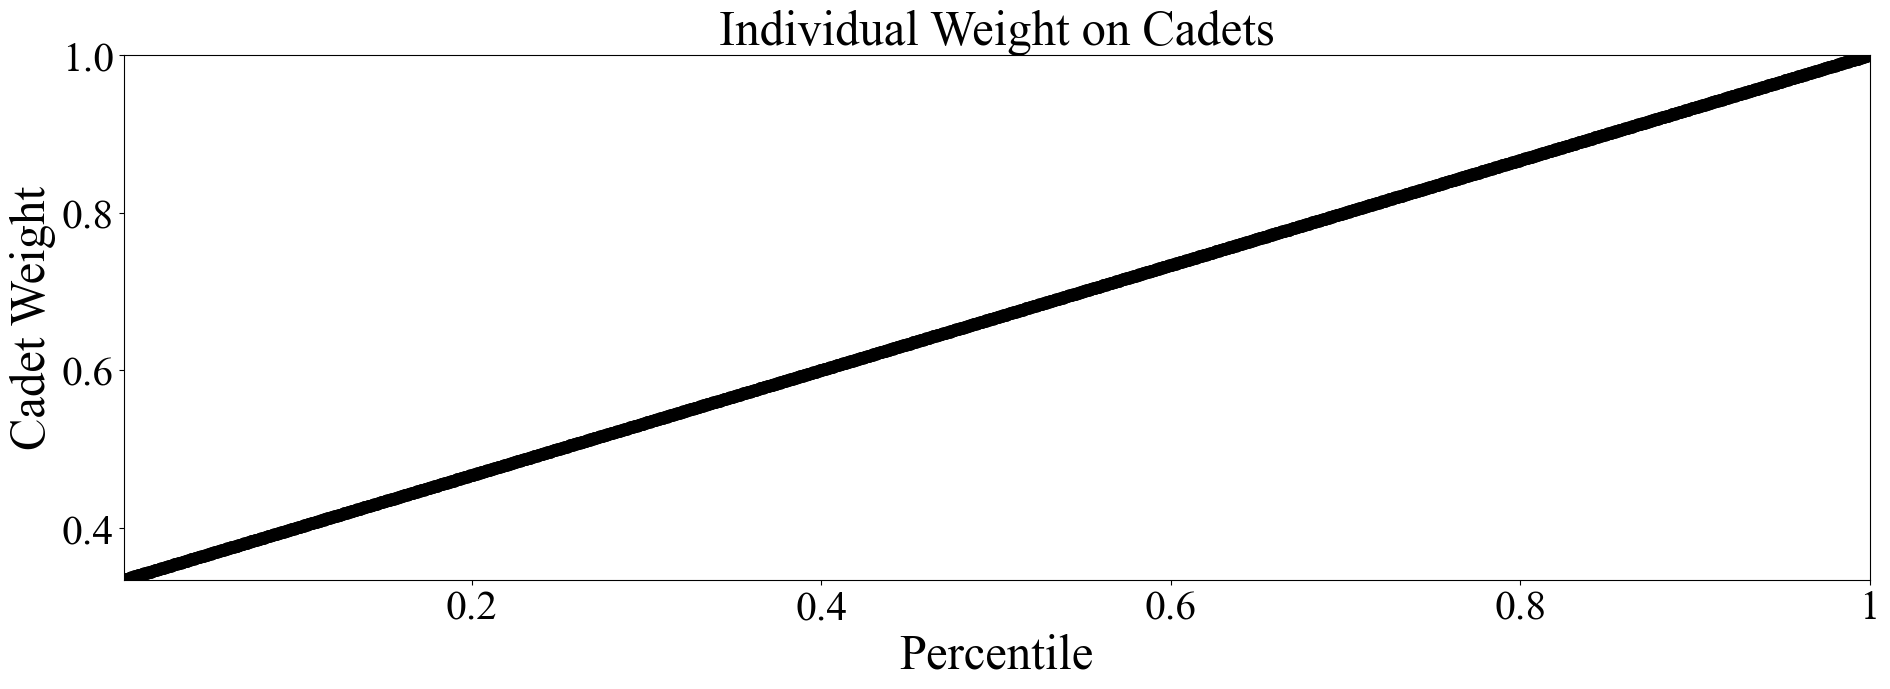

In [33]:
# visualize the function
chart = instance.display_weight_function(cadets=True)

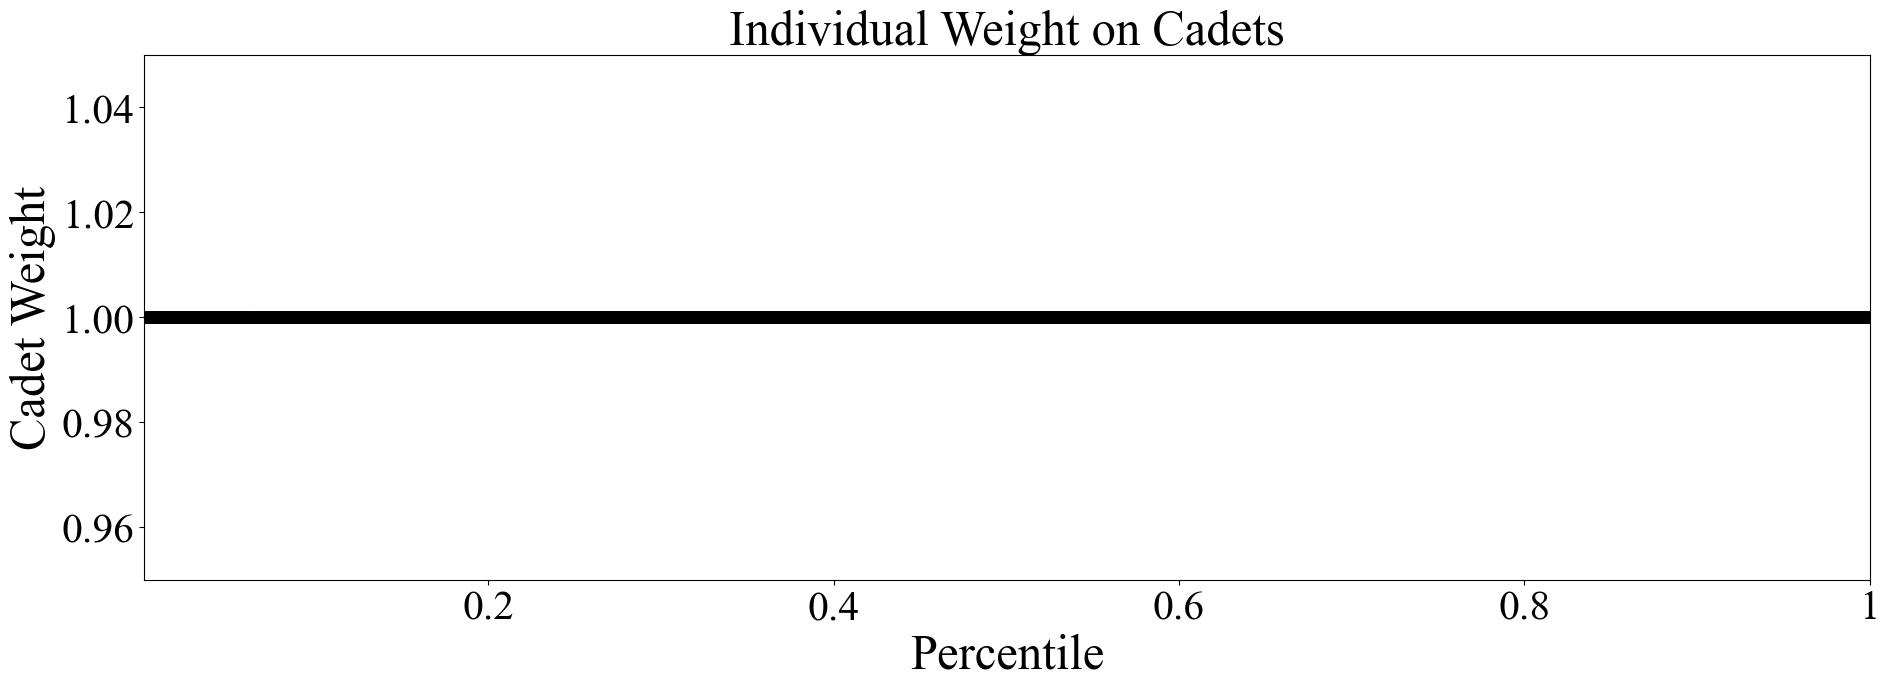

In [34]:
# If we wanted to make all cadets equal, we could do that like this
instance.change_weight_function(cadets=True, function='Equal')

# visualize the function
chart = instance.display_weight_function(cadets=True)

In [35]:
# Change it back
instance.change_weight_function(cadets=True, function='Linear')

In [36]:
# The "overall weights" are pretty straightforward (and mutable as well)
print('Overall Weight on Cadets:', instance.value_parameters['cadets_overall_weight'])
print('Overall Weight on AFSCs:', instance.value_parameters['afscs_overall_weight'])

Overall Weight on Cadets: 0.3
Overall Weight on AFSCs: 0.7


#### Weights on AFSC Objectives

Let's talk about AFSC objectives. Their weights are fairly straightforward, but the value functions need a bit more explanation

In [37]:
# AFSC objective weight (Just printing the shape of it- it'll be MxO where M is number of AFSCs and 
# O is number of objectives!)
print(np.shape(instance.value_parameters['objective_weight']))

(32, 9)


In [38]:
# Let's see the objectives on AFSC "C22" again
j, afsc = 21, 'C22'
indices = instance.value_parameters['K^A'][j]
print('C22 objectives:', objectives[indices])

C22 objectives: ['Merit' 'USAFA Proportion' 'Combined Quota' 'Mandatory' 'Utility']


In [39]:
# The weights on this AFSC's objectives:
print(instance.value_parameters['objective_weight'][j, :])

[0.04169913 0.02080165 0.41669966 0.         0.         0.37500052
 0.         0.         0.14579904]


In [40]:
# Weights are loaded into a large matrix, but not all objective weights are needed (many are zero)
print(instance.value_parameters['objective_weight'][j, indices])  # these are the only ones considered!

[0.04169913 0.02080165 0.41669966 0.37500052 0.14579904]


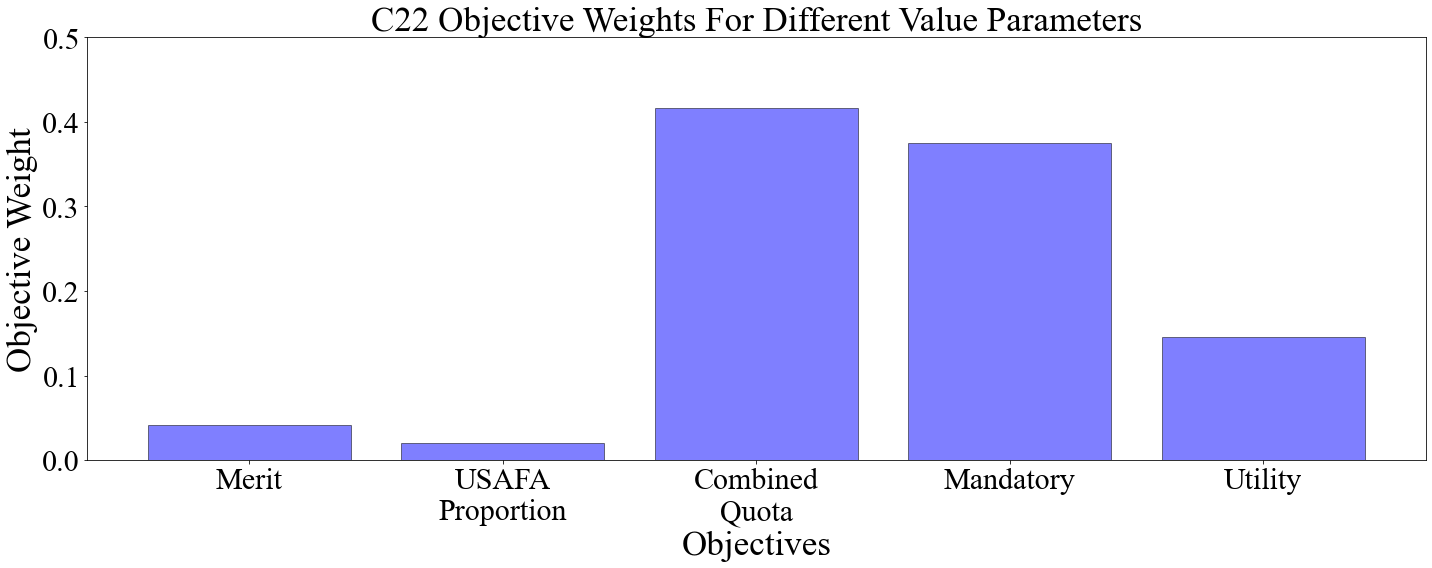

In [41]:
# Objective weights for AFSC "C22"
chart = instance.display_afsc_objective_weights_chart(afsc="C22", figsize=figsize, bar_color='blue', 
                                                      xaxis_tick_size=30, yaxis_tick_size=30, label_size=35)

The "For Different Value Parameters" part is in reference to the fact that this function is usually meant to compare different sets of value parameters with each other.

#### AFSC Objective Value Functions

Just like before with AFSC weight, we could also change objective weights directly for any AFSC very easily. Let's talk about the value functions for these. Quick note: all of the value function things I do are only meant to create non-linear functions to then approximate using linear "breakpoints." The breakpoints are ultimately all that matter to the VFT model, and everything else is just a means of achieving that end result (lists of breakpoint measures and values). I generate value functions in a creative way (at least I think it's creative) and store their basic non-linear structure in strings. The most generalised form is what I label the "vf_string". These vf_strings are specific to a kind of objective function and take in certain parameters to create the exponential "segment dictionary". Let's look at some examples.

In [42]:
# The first is the "Balance" vf_string.
j, afsc = 1, 'C2'  # (index, name)
k, objective = 1, 'Merit'  # (index, name)

vf_string = instance.value_parameters['value_functions'][j, k]
print(vf_string)

Balance|0.12, 0.12, 0.1, 0.1, 0.1, 0.1, 0.7


The "Balance" string takes 7 parameters. They are the "left breakpoint margin" (x location of main exponential segment to the left of the target), the "right breakpoint margin" (x location of main exponential segment to the right of the target), the $\rho$ parameter for segment 1, $\rho$ parameter for segment 2, $\rho$ parameter for segment 3, $\rho$ parameter for segment 4, and the margin y-value (the y value for the segment breakpoints on either side of the target). This function also takes in two AFSC specific parameters: ("target" and "actual"). The target is the desired objective measure (0.5 for merit, for example), and the "actual" is the average merit (or USAFA proportion) of the set of eligible cadets for the AFSC. This is further illustrated for each of the kinds of value functions in the "Value_Function_Builds.xlsx" excel file in the "support" sub-folder. 

In [43]:
# Let's say that we're looking at the Balance Merit objective
print(vf_string)  # The generalized "vf_string" used for the Balance Merit value function for all AFSCs
target = 0.5  # The target is 0.5
actual = 0.4  # Let's say the average merit of eligible cadets for an example AFSC is 0.4

Balance|0.12, 0.12, 0.1, 0.1, 0.1, 0.1, 0.7


We convert this string to a "segment dictionary" that provides the coordinates for the breakpoints to each of the four exponential segments. The $\rho$ parameter for each segment is also listed. The following functions are found in the "Value Parameter Handling" script.

In [44]:
from afccp.core.value_parameter_handling import *
segment_dict = create_segment_dict_from_string(vf_string, target=target, actual=actual)
for segment in segment_dict:
    print(segment, segment_dict[segment])

1 {'x1': 0, 'y1': 0, 'x2': 0.355, 'y2': 0.7, 'rho': -0.1}
2 {'x1': 0.355, 'y1': 0.7, 'x2': 0.5, 'y2': 1, 'rho': 0.1}
3 {'x1': 0.5, 'y1': 1, 'x2': 0.62, 'y2': 0.7, 'rho': 0.1}
4 {'x1': 0.62, 'y1': 0.7, 'x2': 1, 'y2': 0, 'rho': -0.1}


From this non-linear "segment dictionary", I can then linearize the function using a specified number of breakpoints

In [45]:
x, y = value_function_builder(segment_dict, num_breakpoints=24)
print('C2 Average Merit value function breakpoint measures:\n', x)
print('')
print('C2 Average Merit value function breakpoint values:\n', y)

C2 Average Merit value function breakpoint measures:
 [0.      0.05917 0.11833 0.1775  0.23667 0.29583 0.355   0.37917 0.40333
 0.4275  0.45167 0.47583 0.5     0.52    0.54    0.56    0.58    0.6
 0.62    0.68333 0.74667 0.81    0.87333 0.93667 1.     ]

C2 Average Merit value function breakpoint values:
 [0.      0.00587 0.01954 0.05137 0.1255  0.2981  0.7     0.86728 0.94203
 0.97543 0.99035 0.99702 1.      0.9947  0.98436 0.96424 0.92504 0.8487
 0.7     0.28141 0.11203 0.04349 0.01576 0.00454 0.     ]


The code below plots the value function discussed above to further illustrate this concept. The four segments are boxed off and the "main" breakpoints are shown in blue. The other linear breakpoints used are shown in black

(0.0, 1.1)

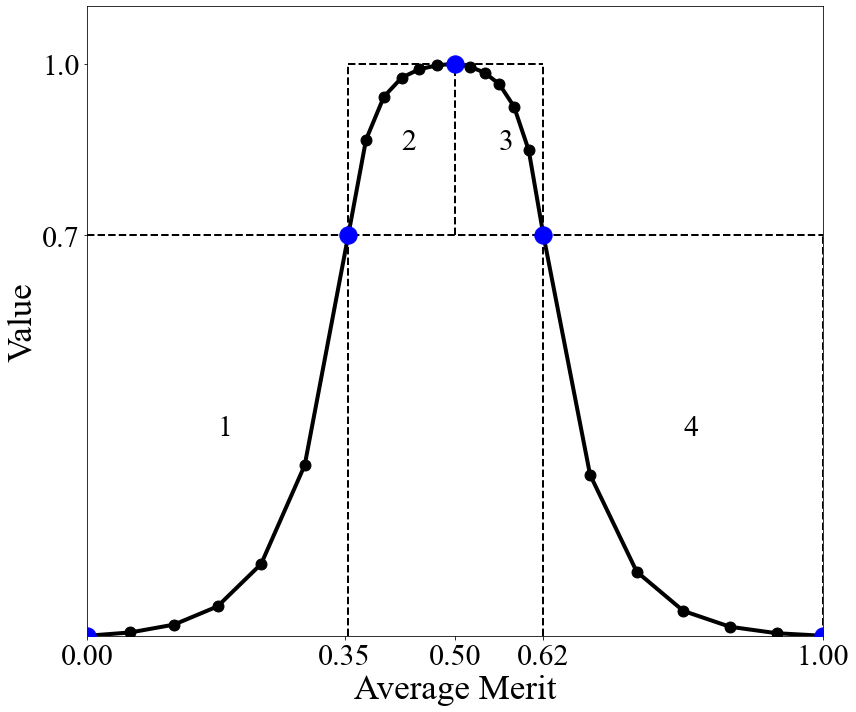

In [46]:
# Create figure
fig, ax = plt.subplots(figsize=(12, 10), facecolor='white', tight_layout=True)
    
# Plot graph
ax.plot(x, y, color='black', linewidth=4)
ax.scatter(x, y, color='black', s=120)

# Gather coordinates
x1 = 0.355  # main left breakpoint x
x2 = 0.62  # main right breakpoint x
margin_y = 0.7  # margin y

# Piecewise divider lines
ax.plot((x1, x1), (0, 1), c="black", linestyle="--", linewidth=2)
ax.plot((target, target), (margin_y, 1), c="black", linestyle="--", linewidth=2)
ax.plot((x2, x2), (0, 1), c="black", linestyle="--", linewidth=2)
ax.plot((1, 1), (0, margin_y), c="black", linestyle="--", linewidth=2)
ax.plot((0, 1), (margin_y, margin_y), c="black", linestyle="--", linewidth=2)
ax.plot((x1, x2), (1, 1), c="black", linestyle="--", linewidth=2)

# Plot divider text
ax.text(x=x1 / 2, y=margin_y / 2, s='1', fontsize=30, c='black')
ax.text(x=x1 + (target - x1) / 2, y=margin_y + (1 - margin_y) / 2, s='2', fontsize=30, c='black')
ax.text(x=target + (x2 - target) / 2, y=margin_y + (1 - margin_y) / 2, s='3', fontsize=30, c='black')
ax.text(x=x2 + (1 - x2) / 2, y=margin_y / 2, s='4', fontsize=30, c='black')

# Plot main breakpoints
bp_x = [0, x1, target, x2, 1]
bp_y = [0, margin_y, 1, margin_y, 0]
ax.scatter(bp_x, bp_y, color='blue', s=300, zorder=3)

# Tick marks
x_ticks = np.array([0, round(x1, 2), target, round(x2, 2), 1])
y_ticks = [margin_y, 1]

# Set tick marks
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

# Adjust axes and ticks
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
ax.yaxis.label.set_size(35)
ax.set_ylabel('Value')
ax.xaxis.label.set_size(35)
ax.set_xlabel('Average Merit')
ax.margins(x=0)
ax.margins(y=0)
plt.ylim(0, 1.1)

Creating value function chart for objective Merit for AFSC C22...


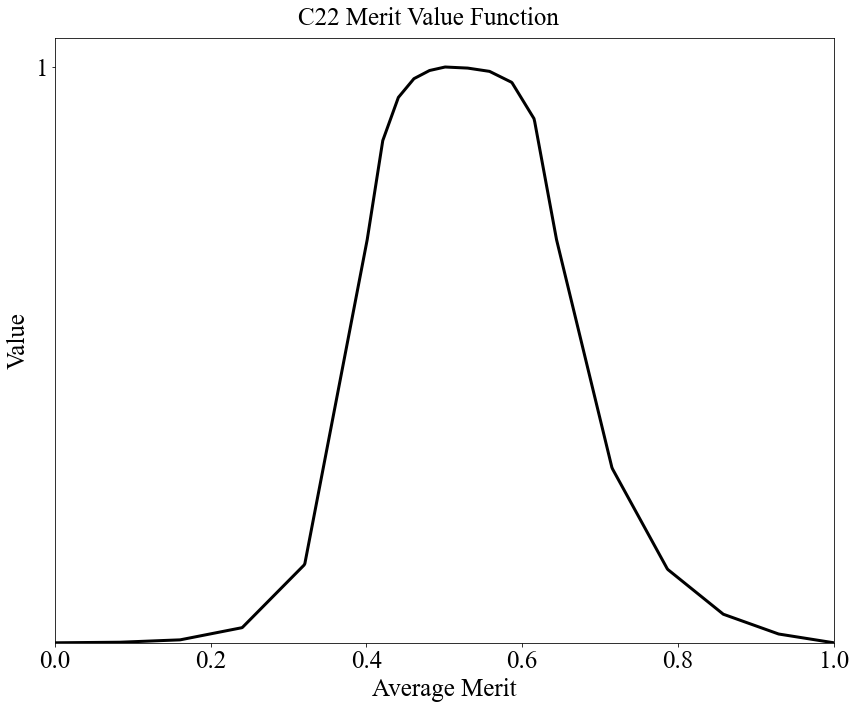

In [47]:
# Now let's see an actual AFSC's value function that is incorporated with the model
chart = instance.show_value_function(afsc='C22', objective='Merit')

In [48]:
# The function breakpoint measures and values are stored here
j, k = 21, 0  # (C22, Balance Merit)
measures = instance.value_parameters['a'][j][k]
values = instance.value_parameters['f^hat'][j][k]
print('Breakpoint measures (x-axis):', measures)
print('Breakpoint values (y-axis):', values)

Breakpoint measures (x-axis): [0.      0.0802  0.1604  0.2406  0.3208  0.401   0.42091 0.44082 0.46074
 0.48065 0.50056 0.52925 0.55794 0.58662 0.61531 0.644   0.7152  0.7864
 0.8576  0.9288  1.     ]
Breakpoint values (y-axis): [0.0000e+00 8.1000e-04 4.9700e-03 2.6320e-02 1.3607e-01 7.0000e-01
 8.7186e-01 9.4682e-01 9.7952e-01 9.9378e-01 1.0000e+00 9.9824e-01
 9.9243e-01 9.7322e-01 9.0975e-01 7.0000e-01 3.0346e-01 1.2772e-01
 4.9820e-02 1.5300e-02 0.0000e+00]


In [49]:
# The actual average merit of the whole class isn't exactly 0.5 (that's why 0.50056 is the target)
print(sum(instance.parameters['merit']) / instance.parameters['N'])
print(instance.value_parameters['objective_target'][j, k])

0.500562429696288
0.500562429696288


These value functions can be changed if need be by changing the value function strings and regenerating the functions from the segment dicts as described previously! (the breakpoint coordinates ($a$, $\hat{f}$) are ultimately what get used by the optimization models)

#### Generating default value parameters

I've talked about what the value parameter set looks like (all the information it contains) but I haven't provided too much discussion on the bigger picture for how we process these value parameters. Up until this point, we've simply imported the value parameters from an excel instance file. What if we have a new set of data and don't want to manually determine all of the parameters every time? Well, we can generate the value parameters too.

The first method is by importing an excel sheet of "default" value parameters. Check this out in the support folder. This is probably the most intuitive method of altering value parameters as they apply to all sets of data. We can take this set of defaults and apply it to a specific problem instance by incorporating information on that specific instance. 

In [50]:
# Import default value parameters from excel
instance.import_default_value_parameters()
print(instance.full_name)  # New set of value parameters was just created!

Importing default value parameters...
Imported.
Real C VP_3


We can figure out the type of data used (Instance C in this case) and then load in that specific set of defaults from the support folder. If it was generated data, we'd use that set. If it was real data (actual AFSCs, not scrubbed AFSCs) we would use that too. There are additional parameters to this method (see the problem_class.py script). 

We can also generate sets of value parameters according to the methodology I discussed in the thesis (sampling the different parameters from normal distributions). This function only works on the real class year instances. By default, quotas and the mandatory degree tier objective are constrained based on how the actual solution was constrained. We can optionally constrain merit too using the "constrain_merit" parameter (I did this for my research). USAFA Proportion objective is constrained for certain AFSCs that don't want too many USAFA cadets.

In [51]:
# Generate weights based on the normal distributions
for _ in range(3): 
    instance.generate_realistic_value_parameters(deterministic=False, constrain_merit=True, add_to_dict=False)
    print('Cadets Overall Weight', instance.value_parameters['cadets_overall_weight'])
    print('AFSC Weight Function', instance.value_parameters['afsc_weight_function'])
    print('Cadet Weight Function', instance.value_parameters['cadet_weight_function'])
    print('')

Generating non-deterministic set of value parameters...
Generated.
Cadets Overall Weight 0.42
AFSC Weight Function Linear
Cadet Weight Function Equal

Generating non-deterministic set of value parameters...
Generated.
Cadets Overall Weight 0.16
AFSC Weight Function Norm
Cadet Weight Function Linear

Generating non-deterministic set of value parameters...
Generated.
Cadets Overall Weight 0.16
AFSC Weight Function Norm
Cadet Weight Function Linear



In [52]:
# We can also generate the value parameters using the expected means as the parameters 
# (like I did for instance C in thesis)
instance.generate_realistic_value_parameters(deterministic=True, constrain_merit=True, add_to_dict=False)
print('Cadets Overall Weight', instance.value_parameters['cadets_overall_weight'])
print('AFSC Weight Function', instance.value_parameters['afsc_weight_function'])
print('Cadet Weight Function', instance.value_parameters['cadet_weight_function'])

Generating deterministic set of value parameters...
Generated.
Cadets Overall Weight 0.3
AFSC Weight Function Piece
Cadet Weight Function Linear


#### Managing sets of value parameters

One thing I have not discussed too much is how the different sets of value parameters are stored within the instance. A set of value parameters is a dictionary, and I also have a bigger dictionary which is the set of sets of value parameters. We can have multiple sets of value parameters, where each set differs in different areas (objective weights, value functions etc.). In the "Real C" instance file, you'll notice I have multiple sets of value parameters (VP, VP_2, VP_3, etc.). These are loaded into the instance object through a dictionary of those value parameters. They are also named.

In [53]:
print('names of sets of value parameters for this instance:', instance.vp_dict.keys())
print('current name of value parameters:', instance.vp_name)

names of sets of value parameters for this instance: dict_keys(['VP', 'VP_2', 'VP_3'])
current name of value parameters: VP_3


The current instance name is "VP_3". This is because we imported the default value parameters for Instance C several cells above and the name associated with this set was "VP_3". Notice that when we generated non-deterministic sets of value parameters, I added the parameter "add_to_dict=False". This prevents the new set of value parameters from being "saved" to the dictionary of sets of value parameters. I just wanted to show how we could generate new sets, and I didn't want to actually keep them. By default, we add the new sets to the dictionary. The current set of value_parameters, however, was also not saved to the dictionary and remains unnamed. Another element to this is that even though we didn't save the new set of value parameters, it is still set to the instance's value parameters attribute.

In [54]:
# Most recent "deterministic" set (cadets overall weight = 0.3)
print(instance.value_parameters['cadets_overall_weight'])

0.3


Even though we generated this set from the "realistic" value parameter generator, it is still actually equal to the set named "VP" that I used in the thesis since it was generated in the same way.

In [55]:
# Already realistically generated deterministic set of value parameters is "VP"
print(instance.vp_dict['VP']['cadets_overall_weight'])

0.3


If I wanted to save this set of value parameters to the dictionary, it would try to set the value parameters named "VP_3" to this set of value parameters, even though it is equivalent to "VP" and would be redundant. To prevent many sets of value parameters in the dictionary from being equal to each other, I created a nifty function to check if the new set of value parameters is actually new. When we go to save this set to the dictionary, it will check if it is already in the dictionary. If it finds a set that is identical to this set, it will not add it and it will change the instance vp_name to what it should be from the dictionary.

In [56]:
# Current name of value parameters
print('current name of value parameters:', instance.vp_name)  # VP_3 

# Current value parameters cadets overall weight (just to show it is different from others)
print('cadets overall weight of current value parameters:', instance.value_parameters['cadets_overall_weight'])

# Actual "VP_3" cadets overall weight
print("cadets overall weight of value parameters named 'VP_3':", instance.vp_dict['VP_3']['cadets_overall_weight'])

# Actual "VP" cadets overall weight
print("cadets overall weight of value parameters named 'VP':", instance.vp_dict['VP']['cadets_overall_weight'])

# Save current set of value parameters to dictionary (tries to save it to VP_3)
instance.save_new_value_parameters_to_dict()

# Found that this "new" set was not actually new, and so it didn't save the set
pass

# The current vp name is now back to "VP" (the instance value parameters object has not changed)
print('updated name of value parameters:', instance.vp_name)  # VP
print('cadets overall weight of current value parameters:', instance.value_parameters['cadets_overall_weight'])

current name of value parameters: VP_3
cadets overall weight of current value parameters: 0.3
cadets overall weight of value parameters named 'VP_3': 0.35
cadets overall weight of value parameters named 'VP': 0.3
updated name of value parameters: VP_4
cadets overall weight of current value parameters: 0.3


In [57]:
# We still have the same "vp_dict" as before! Nothing has changed
print(instance.vp_dict.keys())

dict_keys(['VP', 'VP_2', 'VP_3', 'VP_4'])


If I were to change one thing about this set of value parameters and then save it to the dictionary, it would be added as a new set!

In [58]:
# Change AFSC objective weights for C12
print('before', instance.value_parameters['objective_weight'][11, :])
instance.value_parameters['objective_weight'][11, 0] += 0.02
instance.value_parameters['objective_weight'][11, 2] -= 0.02
print('after', instance.value_parameters['objective_weight'][11, :])

before [0.13114754 0.13114754 0.32786885 0.         0.         0.29508197
 0.         0.         0.1147541 ]
after [0.15114754 0.13114754 0.30786885 0.         0.         0.29508197
 0.         0.         0.1147541 ]


They still sum to 1! Now I can save this set to the dictionary and it'll be added as "VP_4"

In [59]:
instance.save_new_value_parameters_to_dict()
print('current instance vp dict:', instance.vp_dict.keys())
print('current instance vp name:', instance.vp_name)

current instance vp dict: dict_keys(['VP', 'VP_2', 'VP_3', 'VP_4', 'VP_5'])
current instance vp name: VP_5


In [60]:
instance.set_instance_value_parameters(vp_name='VP')